In [1]:
#helpers.py
from numpy import sum, log2
from numpy.random import choice
from pyzx import Graph, VertexType
from numpy import abs, real, diag
from typing import Dict, Any, Optional, Tuple, List

def sample_bitstrings(prob_vector, n_samples):
    """
    Samples bitstrings based on the given probability vector.

    Parameters:
        prob_vector (numpy.ndarray): A vector where each entry represents the probability of a bitstring.
        n_samples (int): The number of samples to generate.

    Returns:
        list: A list of sampled bitstrings.
    """

    prob_vector = prob_vector / sum(prob_vector)

    sampled_indices = choice(len(prob_vector), size=n_samples, p=prob_vector)

    bit_length = int(log2(len(prob_vector)))
    sampled_bitstrings = [format(idx, f'0{bit_length}b') for idx in sampled_indices]
    
    return sampled_bitstrings

def graphical_partial_trace(graph: Graph, qubits: list) -> Graph:
    """
    Computes the graphical partial trace of a graph over specified qubits.

    Parameters:
        graph (Graph): The input graph, must be a state.
        qubits (list): List of qubit indices to trace out.

    Returns:
        Graph: New graph after performing the partial trace.
    """
    gc = graph.copy().adjoint() + graph.copy()
    outs = gc.outputs()
    ins = gc.inputs()
    for q in qubits:
        gc.set_type(outs[q], VertexType.X)
        gc.set_type(ins[q], VertexType.X)
        gc.add_edge((outs[q], ins[q]))
    return gc

def sampler(graph: Graph, qubits: list, n_samples: int) -> list:
    """
    Samples bitstrings from the given graph.

    Parameters:
        graph (Graph): The input graph, must be a state.
        qubits (list): List of qubit indices to trace out. 
                       Sample over remaining qubits.
        n_samples (int): The number of samples to generate.

    Returns:
        list: A list of sampled bitstrings. 
    """
    traced = graphical_partial_trace(graph, qubits)
    sample = abs(real(diag(traced.to_matrix(preserve_scalar=True))))
    return sample_bitstrings(diag(sample), n_samples)

def save_graph_to_tikz(graph, filename="graph.tikz"):
    """
    Saves the TikZ representation of a ZX-graph to a file.

    Parameters:
        graph (zx.Graph): The ZX-graph to save.
        filename (str): The name of the file to save the TikZ representation to.
    """
    with open(filename, "w") as f:
        f.write(graph.to_tikz())

def random_state(n_qubits: int) -> list:
    chars = ['0', '1', '+', '-']
    state = [choice(chars) for _ in range(n_qubits)]
    return state

In [2]:
#error_prop_tools.py
import pyzx as zx
from pyzx.pauliweb import PauliWeb, compute_pauli_webs
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt
import pprint
import re
import matplotlib.pyplot as plt
import pprint
import re
import networkx as nx

def generate_rotated_surface_code(d):
    """
    Generates a 2D qubit map for a rotated surface code of a given distance d,
    drawn on a square grid.

    Args:
        d (int): The distance of the surface code. Must be an odd integer >= 3.

    Returns:
        list[list]: A 2D list representing the qubit map. 0 indicates an
                    empty location. 'd' qubits are data qubits, 'X' and 'Z'
                    qubits are measurement qubits for the stabilizers.
    """
    if not isinstance(d, int) or d < 3 or d % 2 == 0:
        raise ValueError("Distance d must be an odd integer greater than or equal to 3.")

    # The grid size for this layout is (2d+1) x (2d+1)
    size = 2 * d + 1
    sc_map = [[0] * size for _ in range(size)]

    # --- Place Data Qubits ---
    # Data qubits are located at (row, col) where both row and col are odd.
    data_idx = 0
    for r in range(1, 2 * d, 2):
        for c in range(1, 2 * d, 2):
            sc_map[r][c] = f'd{data_idx}'
            data_idx += 1

    # --- Place Measurement Qubits (Stabilizers) ---
    # This layout places measurement qubits at (row, col) where both are even.
    x_idx = 0
    z_idx = 0

    # Place Z stabilizers
    for i in range(1, d):
        for j in range(d + 1):
            if (i + j) % 2 == 0:
                r, c = 2 * i, 2 * j
                if r < size and c < size:
                    sc_map[r][c] = f'Z{z_idx}'
                    z_idx += 1

    # Place X stabilizers
    for i in range(d + 1):
        for j in range(1, d):
            if (i + j) % 2 != 0:
                r, c = 2 * i, 2 * j
                if r < size and c < size:
                    sc_map[r][c] = f'X{x_idx}'
                    x_idx += 1

    return sc_map


def generate_pyzx_and_plot_rotated_code(d):
    """
    Generates a PyZX qubit map and plots the layout for a rotated surface code.

    Args:
        d (int): The distance of the surface code.

    Returns:
        list[tuple]: A list of (x, y) coordinates for PyZX, with data qubits
                     listed first, followed by positionally sorted ancilla qubits.
    """
    # 1. Generate the basic grid map
    sc_map = generate_rotated_surface_code(d)
    print(f"--- Generated Grid Map for d={d} ---")
    pprint.pprint(sc_map)

    # Dictionaries to store qubits before sorting them by their index
    data_qubits = {}
    x_ancillas = {}
    z_ancillas = {}
    
    # 2. Iterate through the map to extract qubit info
    size = len(sc_map)
    for r, row_list in enumerate(sc_map):
        for c, label in enumerate(row_list):
            if label != 0:
                match = re.match(r'([dXZ])(\d+)', label)
                if match:
                    q_type, q_index = match.groups()
                    q_index = int(q_index)
                    
                    # FIX: Convert matrix row 'r' to Cartesian y-coordinate
                    # The origin (0,0) is now at the bottom-left.
                    y_coord = (size - 1) - r
                    coordinate = (c, y_coord)
                    
                    if q_type == 'd':
                        data_qubits[q_index] = {'coord': coordinate, 'label': label}
                    elif q_type == 'X':
                        x_ancillas[q_index] = {'coord': coordinate, 'label': label}
                    elif q_type == 'Z':
                        z_ancillas[q_index] = {'coord': coordinate, 'label': label}

    # 3. Sort data qubits by their index
    sorted_data = [data_qubits[i] for i in sorted(data_qubits.keys())]
    
    # 4. Create a single list of all ancillas and sort by position
    all_ancillas = list(x_ancillas.values()) + list(z_ancillas.values())
    
    # FIX: Sort by y-coordinate descending (top-to-bottom), then x ascending (left-to-right)
    all_ancillas.sort(key=lambda item: (-item['coord'][1], item['coord'][0]))

    # 5. Create the final PyZX map
    pyzx_qubit_map = [item['coord'] for item in sorted_data] + \
                     [item['coord'] for item in all_ancillas]

    # 6. Prepare for plotting
    all_qubits_for_plot = sorted_data + all_ancillas
    
    # 7. Create the plot
    plt.figure(figsize=(10, 10))
    
    # Plot data qubits (blue circles)
    data_x = [c['coord'][0] for c in sorted_data]
    data_y = [c['coord'][1] for c in sorted_data]
    plt.scatter(data_x, data_y, s=200, facecolors='lightblue', edgecolors='black', label='Data Qubits')

    # Plot X ancillas (green squares)
    anc_x_x = [c['coord'][0] for c in x_ancillas.values()]
    anc_x_y = [c['coord'][1] for c in x_ancillas.values()]
    plt.scatter(anc_x_x, anc_x_y, s=220, marker='s', facecolors='lightcoral', edgecolors='black', label='X Ancillas')

    # Plot Z ancillas (yellow squares)
    anc_z_x = [c['coord'][0] for c in z_ancillas.values()]
    anc_z_y = [c['coord'][1] for c in z_ancillas.values()]
    plt.scatter(anc_z_x, anc_z_y, s=220, marker='s', facecolors='lightgreen', edgecolors='black', label='Z Ancillas')

    # Add text labels to each point
    for item in all_qubits_for_plot:
        x, y = item['coord']
        label = item['label']
        plt.text(x, y, label, fontsize=9, ha='center', va='center', weight='bold')
    
    plt.title(f'Surface Code Qubit Map (d={d})', fontsize=16)
    plt.xlabel('X-coordinate', fontsize=12)
    plt.ylabel('Y-coordinate', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    
    max_coord = 2 * d
    plt.xticks(range(max_coord + 1))
    plt.yticks(range(max_coord + 1))
    
    # FIX: The y-axis is no longer inverted.
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.show()

    return pyzx_qubit_map, all_ancillas

def PropagatePauliWeb(g: zx.Graph, initial_error_web: List[Tuple[Tuple[int, int], str]], zwebs, xwebs, add_init=True):
    """
    Takes a list of initial errors, calculates the full propagation and correction
    paths, and returns the final web and a log of corrections.

    Args:
        g: The ZX-diagram of the circuit.
        initial_errors: A list of tuples, where each tuple defines an error as
                        ((vertex1, vertex2), error_type).
        add_init: If True, the output web includes the initial errors.
                  If False, it includes only the resulting corrections.

    Returns:
        A tuple containing (final_web, log), where final_web is a PauliWeb object
        with the error and/or correction paths, and log is a list of strings
        describing the corrections made.
    """
    
    correction_web = PauliWeb(g)
    log = []

    # 3. Determine corrections by checking commutation against the initial error web.
    output_edges = [(o, next(iter(g.neighbors(o)))) for o in g.outputs()]

    for o, n in output_edges:
        # Check Z-web commutation. If it anti-commutes, add an X correction.
        # ALWAYS check against the initial_error_web.
        if o in zwebs and not zwebs[o].commutes_with(initial_error_web):
            log.append(f"Z-web for output {o}: anti-commutes, added X")
            # Add the correction to the dedicated correction_web.
            correction_web.add_half_edge((o, n), 'X')
        else:
            if o in zwebs:
                log.append(f"Z-web for output {o}: commutes")

        # Check X-web commutation. If it anti-commutes, add a Z correction.
        if o in xwebs and not xwebs[o].commutes_with(initial_error_web):
            log.append(f"X-web for output {o}: anti-commutes, added Z")
            correction_web.add_half_edge((o, n), 'Z')
        else:
            if o in xwebs:
                log.append(f"X-web for output {o}: commutes")

    # 4. Decide what to return based on the flag.
    if add_init:
        # Combine initial errors and corrections. The '+' operator on PauliWebs does this.
        final_web = initial_error_web * correction_web
    else:
        # Return only the corrections.
        final_web = correction_web

    return final_web, log

def PropagatePauliError(g: zx.Graph, initial_errors: List[Tuple[Tuple[int, int], str]], add_init=True):
    """
    Takes a list of initial errors, calculates the full propagation and correction
    paths, and returns the final web and a log of corrections.

    Args:
        g: The ZX-diagram of the circuit.
        initial_errors: A list of tuples, where each tuple defines an error as
                        ((vertex1, vertex2), error_type).
        add_init: If True, the output web includes the initial errors.
                  If False, it includes only the resulting corrections.

    Returns:
        A tuple containing (final_web, log), where final_web is a PauliWeb object
        with the error and/or correction paths, and log is a list of strings
        describing the corrections made.
    """

    try:
        order, zwebs, xwebs = compute_pauli_webs(g, backwards=True)
    except (ValueError, KeyError) as e:
        print(f"Error: Could not compute gflow for the graph: {e}")
        return None, []

    # 1. Create a web that will ONLY hold the initial errors.
    initial_error_web = PauliWeb(g)
    for half_edge, error_type in initial_errors:
        initial_error_web.add_half_edge(half_edge, error_type)

    # 2. Create a separate web to accumulate the corrections.
    correction_web = PauliWeb(g)
    log = []

    # 3. Determine corrections by checking commutation against the initial error web.
    output_edges = [(o, next(iter(g.neighbors(o)))) for o in g.outputs()]

    for o, n in output_edges:
        # Check Z-web commutation. If it anti-commutes, add an X correction.
        # ALWAYS check against the initial_error_web.
        if o in zwebs and not zwebs[o].commutes_with(initial_error_web):
            log.append(f"Z-web for output {o}: anti-commutes, added X")
            # Add the correction to the dedicated correction_web.
            correction_web.add_half_edge((o, n), 'X')
        else:
            if o in zwebs:
                log.append(f"Z-web for output {o}: commutes")

        # Check X-web commutation. If it anti-commutes, add a Z correction.
        if o in xwebs and not xwebs[o].commutes_with(initial_error_web):
            log.append(f"X-web for output {o}: anti-commutes, added Z")
            correction_web.add_half_edge((o, n), 'Z')
        else:
            if o in xwebs:
                log.append(f"X-web for output {o}: commutes")

    # 4. Decide what to return based on the flag.
    if add_init:
        # Combine initial errors and corrections. The '+' operator on PauliWebs does this.
        final_web = initial_error_web * correction_web
    else:
        # Return only the corrections.
        final_web = correction_web

    return final_web, log

def get_output_errors(g: zx.Graph, final_web: PauliWeb) -> Dict[int, str]:
    """
    Extracts the final Pauli errors at the circuit's outputs from a PauliWeb.

    Args:
        g: The ZX-diagram of the circuit.
        final_web: The PauliWeb containing the full error and correction paths.

    Returns:
        A dictionary mapping each output vertex to its resulting error ('X', 'Y', or 'Z').
        Returns an empty dictionary if the web is None.
    """
    if not final_web:
        return {}
        
    output_errors = {}
    # The .es dictionary stores the errors on each half-edge
    error_dict = final_web.es
    
    for v_out in g.outputs():
        # Find the neighbor of the output vertex that is inside the circuit
        v_neighbor = next(iter(g.neighbors(v_out)))
        
        # The key for the dictionary is the half-edge from the output *into* the circuit
        half_edge_key = (v_out, v_neighbor)
        
        # Get the error, defaulting to 'I' (Identity) if there is no error on that edge
        error = error_dict.get(half_edge_key, 'I')
        
        # We only care about non-Identity errors
        if error != 'I':
            output_errors[v_out] = error
            
    return output_errors

def generate_rotated_surface_code(d):
    """Generates a 2D qubit map for a rotated surface code."""
    if not isinstance(d, int) or d < 3 or d % 2 == 0:
        raise ValueError("Distance d must be an odd integer >= 3.")
    size = 2 * d + 1
    sc_map = [[0] * size for _ in range(size)]
    data_idx, x_idx, z_idx = 0, 0, 0
    for r in range(1, 2 * d, 2):
        for c in range(1, 2 * d, 2):
            sc_map[r][c] = f'd{data_idx}'; data_idx += 1
    for i in range(1, d):
        for j in range(d + 1):
            if (i + j) % 2 == 0:
                r, c = 2 * i, 2 * j
                if r < size and c < size: sc_map[r][c] = f'Z{z_idx}'; z_idx += 1
    for i in range(d + 1):
        for j in range(1, d):
            if (i + j) % 2 != 0:
                r, c = 2 * i, 2 * j
                if r < size and c < size: sc_map[r][c] = f'X{x_idx}'; x_idx += 1
    return sc_map

def parse_qubit_map(sc_map):
    """Parses the grid map to extract and sort qubit information."""
    data_qubits, x_ancillas, z_ancillas = {}, {}, {}
    size = len(sc_map)
    for r_matrix, row_list in enumerate(sc_map):
        for c, label in enumerate(row_list):
            if label != 0:
                match = re.match(r'([dXZ])(\d+)', label)
                if match:
                    q_type, q_index = match.groups()
                    y_coord = (size - 1) - r_matrix
                    info = {'label': label, 'coord': (c, y_coord), 'matrix_coord': (r_matrix, c)}
                    if q_type == 'd': data_qubits[int(q_index)] = info
                    elif q_type == 'X': x_ancillas[int(q_index)] = info
                    elif q_type == 'Z': z_ancillas[int(q_index)] = info
    
    sorted_data = [data_qubits[i] for i in sorted(data_qubits.keys())]
    
    all_ancillas = list(x_ancillas.values()) + list(z_ancillas.values())
    all_ancillas.sort(key=lambda item: (-item['coord'][1], item['coord'][0]))
    
    return sorted_data, all_ancillas

def find_neighboring_data_qubits(sc_map, r_matrix, c_matrix):
    """
    Finds data qubit neighbors for a given ancilla coordinate in a rotated layout.
    FIXED: This now correctly checks diagonal positions.
    """
    neighbors = []
    size = len(sc_map)
    # In this layout, neighbors are always diagonal to the ancilla
    for dr, dc in [(-1, -1), (-1, 1), (1, -1), (1, 1)]: # Check all four diagonal positions
        nr, nc = r_matrix + dr, c_matrix + dc
        # Check bounds and if there is a qubit at the location
        if 0 <= nr < size and 0 <= nc < size and sc_map[nr][nc] != 0:
            # Check if it's a data qubit
            if sc_map[nr][nc].startswith('d'):
                neighbors.append(sc_map[nr][nc])
    # Return sorted list of data qubit indices (e.g., [0, 1, 3, 4])
    return sorted([int(re.search(r'\d+', n).group()) for n in neighbors])

# --- Part 2: QASM Generation ---

def generate_surface_code_qasm(d, custom_cnot_orderings=None):
    """
    Generates a QASM string for a surface code circuit with configurable CNOT ordering.

    Args:
        d (int): The distance of the code.
        custom_cnot_orderings (dict): A dictionary to specify non-default CNOT orders.
            Example: {'Z0': [3, 2, 1, 0]} reverses the order for Z0.

    Returns:
        str: The complete QASM 2.0 circuit string.
    """
    # 1. Get the layout and qubit information
    sc_map = generate_rotated_surface_code(d)
    data_qubits, ancilla_qubits = parse_qubit_map(sc_map)

    num_data = len(data_qubits)
    num_ancilla = len(ancilla_qubits)

    # 2. Determine connectivity for each ancilla
    connectivity = {}
    for ancilla in ancilla_qubits:
        r_matrix, c_matrix = ancilla['matrix_coord']
        neighbor_indices = find_neighboring_data_qubits(sc_map, r_matrix, c_matrix)
        connectivity[ancilla['label']] = neighbor_indices
        
    # 3. Generate the QASM string
    qasm_header = f"// Surface Code d={d}\n"
    qasm_header += "OPENQASM 2.0;\n"
    qasm_header += 'include "qelib1.inc";\n'
    qasm_header += f"qreg q[{num_data}];\n"
    qasm_header += f"qreg a[{num_ancilla}];\n"
    
    qasm_body = ""
    for i, ancilla in enumerate(ancilla_qubits):
        ancilla_label = ancilla['label']
        ancilla_type = ancilla_label[0]
        
        qasm_body += f"\n// Stabilizer for {ancilla_label} (a[{i}])\n"
        
        connected_qubits = connectivity[ancilla_label]
        
        # Determine the CNOT order
        cnot_order = list(range(len(connected_qubits))) # Default order [0, 1, 2...]
        if custom_cnot_orderings and ancilla_label in custom_cnot_orderings:
            cnot_order = custom_cnot_orderings[ancilla_label]
            qasm_body += f"// Using custom CNOT order: {cnot_order}\n"

        # Apply the ordering to the list of connected qubits
        ordered_qubits = [connected_qubits[k] for k in cnot_order]
        
        # Generate the gates for this stabilizer
        if ancilla_type == 'Z':
            for data_q_idx in ordered_qubits:
                qasm_body += f"cx q[{data_q_idx}], a[{i}];\n"
        elif ancilla_type == 'X':
            qasm_body += f"h a[{i}];\n"
            for data_q_idx in ordered_qubits:
                qasm_body += f"cx a[{i}], q[{data_q_idx}];\n"
            qasm_body += f"h a[{i}];\n"   
    return qasm_header + qasm_body

def get_qubit_errors(g: zx.Graph, qubits_to_check: list, final_web: PauliWeb) -> dict:
    """
    Extracts the final Pauli errors on a specified list of qubits that are outputs.

    Args:
        g: The ZX-diagram of the circuit.
        qubits_to_check: A list of qubit info dicts (containing coords and labels).
        final_web: The PauliWeb containing the full error and correction paths.

    Returns:
        A dictionary mapping each qubit's label to its resulting error ('X', 'Y', or 'Z').
    """
    if not final_web:
        return {}

    # Create a reverse mapping from qubit coordinates to vertex indices
    coord_to_vertex = {coord: v for v, coord in g.qubit_map.items()}
    output_errors = {}
    error_dict = final_web.es

    for qubit_info in qubits_to_check:
        qubit_coord = qubit_info['coord']
        qubit_label = qubit_info['label']

        v_idx = coord_to_vertex.get(qubit_coord)
        # Ensure the qubit is a graph output before checking for an error
        if v_idx is None or v_idx not in g.outputs():
            continue

        v_neighbor = next(iter(g.neighbors(v_idx)))
        half_edge_key = (v_idx, v_neighbor)
        error = error_dict.get(half_edge_key, 'I')

        if error != 'I':
            output_errors[qubit_label] = error

    return output_errors

def get_syndrome(g: zx.Graph, ancillas: list, final_web: PauliWeb) -> list:
    """
    Extracts the error syndrome by identifying which ancilla measurements flipped.

    Args:
        g: The ZX-diagram of the circuit.
        ancillas: A list of the ancilla qubit data (labels and coordinates).
        final_web: The PauliWeb containing the full error and correction paths.

    Returns:
        A list of ancilla qubits that form the syndrome (i.e., "defects").
    """
    # Get all non-identity errors on the ancilla qubits
    ancilla_errors = get_qubit_errors(g, ancillas, final_web)

    syndrome = []
    for ancilla_info in ancillas:
        ancilla_label = ancilla_info['label']
        error = ancilla_errors.get(ancilla_label, 'I')

        # Determine if the ancilla measurement is flipped.
        # A Z-stabilizer measures in the Z-basis, so an X or Y error flips it.
        # An X-stabilizer measures in the X-basis, so a Z or Y error flips it.
        ancilla_type = ancilla_label[0]

        is_defect = False
        if ancilla_type == 'Z' and error in ('X', 'Y'):
            is_defect = True
        elif ancilla_type == 'X' and error in ('Z', 'Y'):
            is_defect = True

        if is_defect:
            syndrome.append(ancilla_info)

    return syndrome

def create_matching_graph(syndrome: list) -> nx.Graph:
    """
    Creates a graph for the MWPM decoder.

    Args:
        syndrome: A list of defective ancilla qubits.

    Returns:
        A networkx graph where nodes are defective ancillas and edge weights are
        the Manhattan distance between them.
    """
    matching_graph = nx.Graph()
    for i in range(len(syndrome)):
        for j in range(i + 1, len(syndrome)):
            ancilla1 = syndrome[i]
            ancilla2 = syndrome[j]
            
            coord1 = ancilla1['coord']
            coord2 = ancilla2['coord']
            
            # Calculate Manhattan distance
            distance = abs(coord1[0] - coord2[0]) + abs(coord1[1] - coord2[1])
            
            matching_graph.add_edge(i, j, weight=distance)
            
    return matching_graph

In [3]:
# from error_prop_tools import *
# from helpers import *
import pyzx as zx
import numpy as np
import scipy as sp
import sympy as sy
import random
import matplotlib.pyplot as plt
from fractions import Fraction
import quimb.tensor as qtn
import pprint as pp

--- Generated Grid Map for d=3 ---
[[0, 0, 'X0', 0, 0, 0, 0],
 [0, 'd0', 0, 'd1', 0, 'd2', 0],
 [0, 0, 'Z0', 0, 'X1', 0, 'Z1'],
 [0, 'd3', 0, 'd4', 0, 'd5', 0],
 ['Z2', 0, 'X2', 0, 'Z3', 0, 0],
 [0, 'd6', 0, 'd7', 0, 'd8', 0],
 [0, 0, 0, 0, 'X3', 0, 0]]


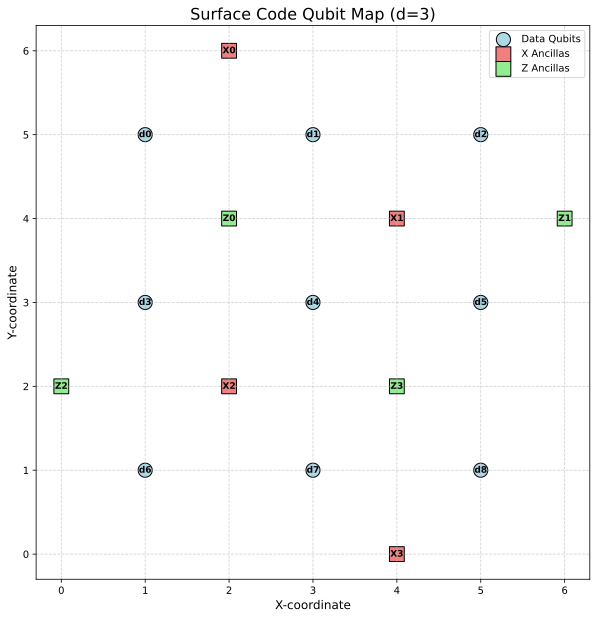


--- Generated PyZX Qubit Map (Corrected Coordinates) ---
{0: (1, 1),
 1: (1, 3),
 2: (1, 5),
 3: (3, 1),
 4: (3, 3),
 5: (3, 5),
 6: (5, 1),
 7: (5, 3),
 8: (5, 5),
 9: (0, 2),
 10: (2, 2),
 11: (2, 4),
 12: (2, 6),
 13: (4, 0),
 14: (4, 2),
 15: (4, 4),
 16: (6, 4),
 17: (3, 2)}


In [4]:
DISTANCE = 3

_, sorted_ancillas = generate_pyzx_and_plot_rotated_code(DISTANCE)

print("\n--- Generated PyZX Qubit Map (Corrected Coordinates) ---")

pyzx_map_rotated = {2: (1, 5),
                    5: (3, 5),
                    8: (5, 5),
                    1: (1, 3),
                    4: (3, 3),
                    7: (5, 3),
                    0: (1, 1),
                    3: (3, 1),
                    6: (5, 1),
                    12: (2, 6),
                    11: (2, 4),
                    15: (4, 4),
                    16: (6, 4),
                    9: (0, 2),
                    10: (2, 2),
                    14: (4, 2),
                    13: (4, 0),
                    17: (3, 2),
                    }

pprint.pprint(pyzx_map_rotated)

In [5]:
custom_orders = {
    'Z0': [1, 2, 0, 3],
    'X1': [1, 2, 0, 3],
    'X2': [1, 2, 0, 3],
    'Z3': [1, 2, 0, 3]
}
custom_qasm_string = generate_surface_code_qasm(DISTANCE, custom_cnot_orderings=custom_orders)
g = zx.sqasm(custom_qasm_string, simplify=False)
zx.id_simp(g)
g.map_qubits(pyzx_map_rotated)
zx.draw(g)

In [6]:
encoder = zx.Graph()
for i in range(9):
    a = encoder.add_vertex(zx.VertexType.X, qubit = i, row = 1, phase=0)
    b = encoder.add_vertex(zx.VertexType.BOUNDARY, qubit = i, row = 2, phase=0)
    encoder.add_edge((a, b))
for i in [10, 12, 13, 15]:
    a = encoder.add_vertex(zx.VertexType.Z, qubit = i , row = 1, phase=0)

#Z0
encoder.add_edge((18, 0))
encoder.add_edge((18, 2))
encoder.add_edge((18, 6))
encoder.add_edge((18, 8))
#Z1
encoder.add_edge((19, 4))
encoder.add_edge((19, 10))

#Z2
encoder.add_edge((20, 6))
encoder.add_edge((20, 12))

#Z3
encoder.add_edge((21, 8))
encoder.add_edge((21, 10))
encoder.add_edge((21, 14))
encoder.add_edge((21, 16))

#logical input
in0 = encoder.add_vertex(zx.VertexType.Z, qubit = 17, row = 0, phase=0)
in1 = encoder.add_vertex(zx.VertexType.BOUNDARY, qubit = 17, row = -1, phase=0)
encoder.add_edge((in0, in1))

encoder.add_edge((in0, 0))
encoder.add_edge((in0, 6))
encoder.add_edge((in0, 12))

#map n draw
encoder.set_outputs([1, 3, 5, 7, 9, 11, 13, 15, 17])
encoder.set_inputs([23])
encoder.map_qubits(pyzx_map_rotated)
encoder_c = encoder.copy()

Measurments are detectors so they will always be |0> if no noise, so symbols are redundant. The error at the node determines the measurment outcome. 

In [12]:
g_round0 = g.copy()
g_round0.apply_state('/////////00000000')
g_round0.apply_effect('/////////00000000')
# symbols1 = sy.symbols('1X0 1Z0 1X1 1Z1 1Z2 1X2 1Z3 1X3')
# for i in range(8):
#     g_round0.set_phase(i+74, symbols1[i])

process = encoder_c.copy()
process.compose(g_round0)

g_round1 = g.copy()
g_round1.apply_state('/////////00000000')
g_round1.apply_effect('/////////00000000')
# symbols2 = sy.symbols('2X0 2Z0 2X1 2Z1 2Z2 2X2 2Z3 2X3')
# for i in range(8):
#     g_round1.set_phase(i+74, symbols2[i])

process.compose(g_round1)

g_round2 = g.copy()
g_round2.apply_state('/////////00000000')
g_round2.apply_effect('/////////00000000')
# symbols3 = sy.symbols('3X0 3Z0 3X1 3Z1 3Z2 3X2 3Z3 3X3')
# for i in range(8):
#     g_round2.set_phase(i+74, symbols3[i])

process.compose(g_round2)

corr_s = """
qreg d[9];
"""
for i in range(9):
    corr_s += f"x d[{i}];\n"
    corr_s += f"z d[{i}];\n"

corr = zx.sqasm(corr_s)
corr.map_qubits(pyzx_map_rotated)

x_symbols = sy.symbols('x:9')
z_symbols = sy.symbols('z:9')

for i, j in enumerate(range(0, 17, 2)):
    corr.set_phase(9+j, x_symbols[i])
    corr.set_phase(9+j+1, z_symbols[i])

process.compose(corr)
process.compose(encoder_c.adjoint())
process.apply_state('0')
zx.draw(process, True)


Each round generates a binary vector $[rX0,...,rX3]$ per round r. The data qubits accumulate some overall X and Z errors. The goal of decoding is to infer the 18 final data error bits from the 3 rounds of syndrome measurment bits.

Lets model a memory experiment.

In [8]:
symbols_vid_dict = {}
symbols_val_dict = {}
for j, i in enumerate(symbols1):
    symbols_vid_dict[i] = j+89
    symbols_val_dict[i] = 0
for j, i in enumerate(symbols2):
    symbols_vid_dict[i] = j+162
    symbols_val_dict[i] = 0
for j, i in enumerate(symbols3):
    symbols_vid_dict[i] = j+235
    symbols_val_dict[i] = 0
for j, i in enumerate(x_symbols):
    symbols_vid_dict[i] = j+243+j
    symbols_val_dict[i] = 0
for j, i in enumerate(z_symbols):
    symbols_vid_dict[i] = j+244+j
    symbols_val_dict[i] = 0

In [9]:
p = process.copy()
p.set_inputs([14])
p.set_outputs([239])
p.apply_state('0')
zx.full_reduce(p)
zx.draw(p,True)

for v in p.vertices():
    if type(p.phase(v)) == sy.Mod:
        p.set_phase(v, int(p.phase(v).subs(symbols_val_dict)))

zx.full_reduce(p)
p.normalize()
zx.draw(p,True)

In [ ]:
def graph_from_web_and_print(web):
    g = web.graph_with_errors()
    g.apply_state('0'*17)
    sampler = graphical_partial_trace(g, range(9))
    zx.full_reduce(sampler)
    sampler.normalize()
    zx.id_simp(sampler)
    zx.draw(sampler, True) 
    return sampler

id_dict =  {65: 'd0',
            66: 'd1',
            67: 'd2',
            68: 'd3',
            69: 'd4',
            70: 'd5',
            71: 'd6',
            72: 'd7',
            73: 'd8',
            74: 'X0',
            75: 'Z0',
            76: 'X1',
            77: 'Z1',
            78: 'Z2',
            79: 'X2',
            80: 'Z3',
            81: 'X3'}

ancillas = [item[0] for item in list(id_dict.items())]

In [11]:
sim_r1 = g.copy()
init_err_r1 = zx.pauliweb.PauliWeb.random(sim_r1)
order_r1, zwebs_r1, xwebs_r1 = compute_pauli_webs(sim_r1, backwards=True)
err_r1, log_r1 = PropagatePauliWeb(sim_r1, init_err_r1, zwebs_r1, xwebs_r1, add_init=False)
rho_r1 = graph_from_web_and_print(err_r1)
output_errs_r1 = get_output_errors(sim_r1, err_r1)

data_err_r1 = zx.pauliweb.PauliWeb(sim_r1)
for i in output_errs_r1.items():
    print(id_dict[i[0]], i[1])

for i in err_r1.half_edges().items():
    if i[0][0] in ancillas[0:8] or i[0][1] in ancillas:
        data_err_r1.add_half_edge(i[0], i[1])
zx.draw(sim_r1, True, pauli_web=data_err_r1)

sim_r2 = g.copy()
init_err_r2 = zx.pauliweb.PauliWeb.random(sim_r2)*data_err_r1
order_r2, zwebs_r2, xwebs_r2 = compute_pauli_webs(sim_r2, backwards=True)
err_r2, log_r2 = PropagatePauliWeb(sim_r2, init_err_r2, zwebs_r2, xwebs_r2, add_init=False)
rho_r2 = graph_from_web_and_print(err_r2)
output_errs_r2 = get_output_errors(sim_r2, err_r2)

data_err_r2 = zx.pauliweb.PauliWeb(sim_r1)
for i in output_errs_r2.items():
    print(id_dict[i[0]], i[1])

for i in err_r2.half_edges().items():
    if i[0][0] in ancillas[0:8] or i[0][1] in ancillas:
        data_err_r2.add_half_edge(i[0], i[1])
zx.draw(sim_r2, True, pauli_web=data_err_r2)

sim_r3 = g.copy()
init_err_r3 = zx.pauliweb.PauliWeb.random(sim_r3)*data_err_r2
order_r3, zwebs_r3, xwebs_r3 = compute_pauli_webs(sim_r3, backwards=True)
err_r3, log_r3 = PropagatePauliWeb(sim_r3, init_err_r3, zwebs_r3, xwebs_r3, add_init=False)
rho_r1 = graph_from_web_and_print(err_r3)
output_errs_r3 = get_output_errors(sim_r3, err_r3)
for i in output_errs_r3.items():
    print(id_dict[i[0]], i[1])
zx.draw(sim_r3, True, pauli_web=err_r3)

d0 Z
d1 Z
d2 X
d4 Z
d6 X
d7 Z
d8 X
X0 Y
Z0 X
X1 Z
Z1 Y
Z2 Z
Z3 X
X3 Z


d0 Y
d1 Y
d2 Y
d3 Z
d4 Y
d5 Z
d7 Y
d8 Y
Z0 Z
X1 Y
Z1 X
Z2 Z
X2 Z
Z3 Y
X3 X


d0 Z
d1 Z
d2 Z
d4 X
d5 X
d6 X
d7 X
d8 Z
X0 X
Z0 X
Z1 Z
X2 X
X3 Z


Distance 3 Surface code is 3 rounds, on the first round error is injected and propagated to the end. Then we save the syndrome errors, write the data errors to the start of the next round, inject new errors, and propagate it again. Then do the previous step again and then the final data errors are to be learned from the syndromes. 

For Hook error analysis we inject a single error at the hook mechanism position. During different cycles.